In [1]:
import pandas as pd
# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_bupa = pd.read_csv("experiments/data/liver_disorders/bupa.data", sep=",", header=None, names = ["mcv",
"alkphos",
"sgpt",
"sgot",
"gammagt",
"drinks",
"selector"])

data_bupa= data_bupa.drop(columns=["selector"])
data_bupa["drinks"] = (data_bupa["drinks"] >= 3).astype("int")

costs_bupa = pd.read_csv("experiments/data/liver_disorders/bupa-liver.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_bupa[1] = costs_bupa[1].str.strip(",").astype(float)
costs_bupa.index = costs_bupa.index.str.strip(":")

In [2]:
costs_bupa

,1,2
0,,
mcv,7.27,5.17
alkphos,7.27,5.17
sgpt,7.27,5.17
sgot,7.27,5.17
gammagt,9.86,7.76


In [3]:
from sklearn.model_selection import train_test_split
from skpsl import ProbabilisticScoringList


X, y = data_bupa.iloc[:,:-1].to_numpy(), data_bupa.iloc[:,-1].to_numpy() 


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [4]:
from experiments.util import DataLoader
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

score_set = {-3,-2,-1,1,2,3}

# X, y = DataLoader("experiments/data/").load("thorax")
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=1 / 3, random_state=1
# )


In [5]:
from sklearn.metrics import brier_score_loss
# pipeline_psl = make_pipeline(
#     SimpleImputer(missing_values=-1, strategy="most_frequent"),
#     ProbabilisticScoringList(score_set=score_set),
# )

# pipeline_psl.fit(X_train, y_train)
# imputer = pipeline_psl[0]
# psl = pipeline_psl[1]
psl = ProbabilisticScoringList(score_set=score_set).fit(X_train, y_train)

In [6]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [7]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
from sklearn.tree import DecisionTreeClassifier


# pipeline_dt = make_pipeline(
#     SimpleImputer(missing_values=-1, strategy="most_frequent"),
#     DecisionTreeClassifier(),
# )

# pipeline_dt.fit(X_train, y_train)
# imputer = pipeline_dt[0]
# dt = pipeline_dt[1]
dt = DecisionTreeClassifier().fit(X_train, y_train)

In [9]:
y_proba_psl = psl.predict_proba(X_test)
brier_score_loss(y_test, y_proba_psl[:,1])
y_proba_xgb = xgb.predict_proba(X_test)
brier_score_loss(y_test, y_proba_xgb[:,1])

0.35188514565686385

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

def get_bupa_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            if i == 0:
                cost += costs_bupa.iloc[s,0]
            else:
                cost += costs_bupa.iloc[s,1]
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_bupa_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

In [11]:
import numpy as np

def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf

            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists


In [40]:
briers_psl = []
briers_dt = []

costs_psl = []
costs_dt = []

from sklearn.metrics import accuracy_score

num_features = X.shape[1]


for i in range(0,num_features):
    y_prob_psl = psl.predict_proba(X_test, k=i)

    print(psl[i].features)
    psl_cost = len(X_test) * get_bupa_cost_for_feature_subset(psl[i].features) 
    print("psl:", psl[i].features)

    y_prob_dt, used_features = limited_feature_predict(dt, X_test, max_features=i)

    dt_cost = 0

    for feature_subset in used_features:
        dt_cost += get_bupa_cost_for_feature_subset(feature_subset)

    print("dt:", len(used_features), dt_cost)

    briers_psl.append(brier_score_loss(y_test, np.argmax(y_prob_psl,axis=1)))
    briers_dt.append(brier_score_loss(y_test, np.argmax(y_prob_dt,axis=1)))

    costs_psl.append(psl_cost)
    costs_dt.append(dt_cost)


[]
psl: []
dt: 87 0.0
[3]
psl: [3]
dt: 87 632.4899999999992
[3, 1]
psl: [3, 1]
dt: 87 1276.5299999999988
[3, 1, 0]
psl: [3, 1, 0]
dt: 87 1749.6400000000026
[3, 1, 0, 2]
psl: [3, 1, 0, 2]
dt: 87 2132.2199999999966


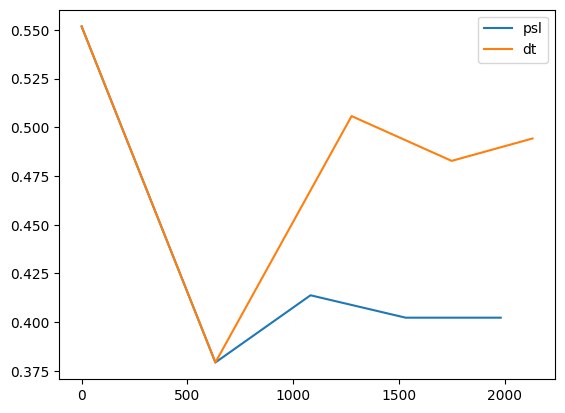

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.plot(costs_psl, briers_psl, label="psl")
plt.plot(costs_dt, briers_dt, label="dt")
plt.legend()
plt.show()

87

In [14]:
get_bupa_cost_for_feature_subset([1,4])

15.03